In [7]:
import numpy as np
import matplotlib.pyplot as plt

# kinetic parameters with assumed units:
aM = 15.1745   # 1/hr, transcription rate per nM of free DNA: DA--> DA+M
aP = 1         # 1/hr, translation rate per nM of mRNA: M-->M+P
aF = 1         # 1/hr, conversion rate from protein to repressor: P-->P+F
bM = 1         # 1/hr, mRNA degradation rate: M--> ∅
bP = 1         # 1/hr, protein degradation rate : P--> ∅
bF = 1         # 1/hr, repressor degradation rate: F--> ∅
k_f = 200       # 1/(nM·hr), binding rate constant for free DNA and repressor: DA+F--> DR
k_b = 50        # 1/hr, unbinding rate constant for the DNA-repressor complex: DR--> DA+F
DT = 165    # nM, total DNA concentration

In [8]:


# parameters (same units as before)
alpha_M = 15.1745
alpha_P = 1.0
alpha_F = 1.0
beta_M  = 1.0
beta_P  = 1.0
beta_F  = 1.0
K_d = (k_b + beta_F)/k_f
    # kb defined earlier
n_DT    = 165.0
Ω       = 1.0               # volume

# Propensities

In [9]:
def props_sQSSA(state):
    nM, nP, nF = state

    # R1:    φ → M
    rho1 = alpha_M * n_DT * (K_d*Ω) / (nF + K_d*Ω)

    # R2:    M → M + P
    rho2 = alpha_P * nM

    # R3:    P → P + F
    rho3 = alpha_F * nP

    # R4:    M → ∅
    rho4 = beta_M * nM

    # R5:    P → ∅
    rho5 = beta_P * nP

    # R6:    F → ∅
    #     here the effective "off" rate is beta_F plus the
    #     slow release of F from DNA·F complex:
    rho6 = beta_F * ( nF + n_DT * nF/(nF + K_d*Ω) )

    return np.array([rho1, rho2, rho3, rho4, rho5, rho6])


# Gillespie Algorithm

In [10]:
def simulate_sQSSA(omega=1.0, t_max=40.0, seed=0):
    np.random.seed(seed)
    state = np.array([0,0,0], dtype=float)  # [M, P, F]
    t = 0.0
    times = [t]
    traj  = [state.copy()]

    while t < t_max:
        props = prop_sQSSA(state, omega)
        a0 = props.sum()
        if a0 == 0:
            break

        # draw time to next reaction
        r1 = np.random.rand()
        dt = -np.log(r1) / a0
        t += dt

        # pick which reaction fires
        r2 = np.random.rand() * a0
        j  = np.searchsorted(np.cumsum(props), r2)

        # update state
        if   j == 0: state[0] += 1    # R1: +M
        elif j == 1: state[0] -= 1    # R2: -M
        elif j == 2: state[1] += 1    # R3: +P
        elif j == 3: state[1] -= 1    # R4: -P
        elif j == 4: state[2] += 1    # R5: +F
        else:        state[2] -= 1    # R6: -F

        times.append(t)
        traj.append(state.copy())

    return np.array(times), np.array(traj)

# Trajectories

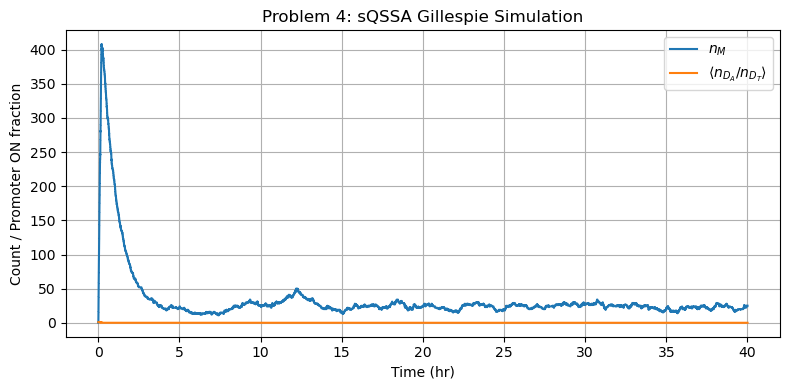

In [11]:

# run one trajectory
times, traj = simulate_sQSSA(omega=1.0)

# ================
#  PLOTTING
# ================
plt.figure(figsize=(8,4))
# mRNA
plt.step(times, traj[:,0], where='post', label=r'$n_M$', color='C0')
# effective promoter ON fraction φ(t)
phi_traj = (Kd * 1.0) / (traj[:,2] + Kd * 1.0)
plt.step(times, phi_traj,   where='post', label=r'$\langle n_{D_A}/n_{D_T}\rangle$', color='C1')

plt.xlabel('Time (hr)')
plt.ylabel('Count / Promoter ON fraction')
plt.title('Problem 4: sQSSA Gillespie Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()